In [1]:
import pandas as pd
import numpy as np
from gensim.models import word2vec
from sklearn.manifold import TSNE
import plotly_express as px

In [2]:
OHCO = ['company_id', 'link_num', 'sent_num', 'token_num']

In [3]:
TOKENS = pd.read_csv('TOKENS.csv').set_index(OHCO)
TOKENS

pos_tuple  pos  \
company_id link_num sent_num token_num                                 
1          0        0        0          ('Manufacturer', 'NNP')  NNP   
                             3              ('Hardware', 'NNP')  NNP   
                             4                ('Custom', 'NNP')  NNP   
                             5                 ('Metal', 'NNP')  NNP   
                             6              ('Crafters', 'NNP')  NNP   
...                                                         ...  ...   
1222       2        4        0                ('Success', 'NN')   NN   
                    5        1                ('message', 'NN')   NN   
                    6        3             ('PentaCast', 'NNP')  NNP   
                             4                   ('Inc', 'NNP')  NNP   
                    7        0                    ('Tel', 'NN')   NN   

                                           token_str      term_str  
company_id link_num sent_num token_num                              
1          0        0        0          Manufacturer  manufacturer  
                             3              Hardware      hardware  
                             4                Custom        custom  
                             5                 Metal         metal  
                             6              Crafters      crafters  
...                                              ...           ...  
1222       2        4        0               Success       success  
                    5        1               message       message  
                    6        3             PentaCast     pentacast  
                             4                   Inc           inc  
                    7        0                   Tel           tel  

[144151 rows x 4 columns]

In [4]:
VOCAB = pd.read_csv('VOCAB.csv')
VOCAB

term_str     n         p          i  n_chars max_pos  n_pos  \
0        quality  1369  0.009497   6.718315        7      NN      3   
1       castings  1228  0.008519   6.875126        8     NNS      3   
2       products  1199  0.008318   6.909605        8     NNS      4   
3        casting  1194  0.008283   6.915634        7     NNP      2   
4        contact   944  0.006549   7.254578        7     NNP      2   
...          ...   ...       ...        ...      ...     ...    ...   
12646      beane     1  0.000007  17.137221        5     NNP      1   
12647      lucas     1  0.000007  17.137221        5     NNP      1   
12648  hernandez     1  0.000007  17.137221        9     NNP      1   
12649    enrique     1  0.000007  17.137221        7     NNP      1   
12650   bcormier     1  0.000007  17.137221        8      NN      1   

                            cat_pos      dfidf  mean_tfidf  
0              {'NNS', 'NNP', 'NN'}  22.920115    0.020423  
1            {'NNS', 'NNP', 'NNPS'}  44.741763    0.056828  
2      {'NNS', 'NNP', 'NN', 'NNPS'}  33.358238    0.024701  
3                     {'NNP', 'NN'}  45.154499    0.051122  
4                     {'NNP', 'NN'}  35.475367    0.022390  
...                             ...        ...         ...  
12646                       {'NNP'}   2.477121    0.000550  
12647                       {'NNP'}   2.477121    0.000550  
12648                       {'NNP'}   2.477121    0.000550  
12649                       {'NNP'}   2.477121    0.000550  
12650                        {'NN'}   2.477121    0.000590  

[12651 rows x 10 columns]

In [5]:
BAG = ['company_id', 'link_num']
DOCS = TOKENS[~TOKENS.pos.str.match('NNPS?')]\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()
DOCS = [doc for doc in DOCS if len(doc) > 1] # Lose single word docs

## Model 1

In [6]:
# word2vec parameters
w2v_params = dict(
    window = 5,
    vector_size = 200,
    min_count = 50,
    workers = 4
)

In [7]:
model_1 = word2vec.Word2Vec(DOCS, **w2v_params)

In [8]:
coords_1  = pd.DataFrame(
    dict(
        vector = [model_1.wv.get_vector(w) for w in model_1.wv.index_to_key], 
        term_str = model_1.wv.index_to_key
    )).set_index('term_str')

In [9]:
tsne_engine_1 = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
tsne_model_1 = tsne_engine_1.fit_transform(coords_1.vector.to_list())

In [10]:
coords_1 ['x'] = tsne_model_1[:,0]
coords_1 ['y'] = tsne_model_1[:,1]

In [11]:
if coords_1 .shape[1] == 3:
    coords_1  = coords_1.merge(VOCAB.reset_index(), on='term_str')
    coords_1  = coords_1.set_index('term_str')

### Terms and embeddings, either added to the VOCAB table or as a separate table with a shared index with the VOCAB table.

In [12]:
coords_1 

vector          x  \
term_str                                                                    
quality      [0.09249241, -0.116015606, -0.16006157, 0.1318...  -9.367032   
products     [0.07598036, -0.054508217, -0.103563994, 0.063...  -3.444940   
castings     [0.0038468952, -0.20906174, -0.2705563, 0.1879... -13.999911   
customers    [0.09489397, -0.08802198, -0.13401794, 0.10016...  -6.956171   
parts        [0.030684829, -0.15238327, -0.21057789, 0.1664... -12.850760   
...                                                        ...        ...   
program      [0.052341968, -0.018735617, -0.06385613, 0.043...   3.068497   
protection   [0.01873666, 0.026819771, -0.0018076919, -0.01...  11.517477   
software     [0.04286183, 0.008046827, -0.036799032, 0.0128...   8.234579   
file         [0.026348773, 0.07565432, 0.022618858, -0.0352...  13.823512   
maintenance  [0.04258256, -0.020455463, -0.061291948, 0.034...   3.076071   

                     y  index     n         p          i  n_chars max_pos  \
term_str                                                                    
quality      11.976635      0  1369  0.009497   6.718315        7      NN   
products      6.695321      2  1199  0.008318   6.909605        8     NNS   
castings     12.495385      1  1228  0.008519   6.875126        8     NNS   
customers    10.231357     13   678  0.004703   7.732080        9     NNS   
parts        12.102024     10   743  0.005154   7.600003        5     NNS   
...                ...    ...   ...       ...        ...      ...     ...   
program      -3.666410    399    63  0.000437  11.159941        7      NN   
protection   -6.241228    169   128  0.000888  10.137221       10     NNP   
software     -4.743595    442    59  0.000409  11.254578        8      NN   
file         -6.957466    504    52  0.000361  11.436782        4      NN   
maintenance  -2.245626    307    81  0.000562  10.797371       11      NN   

             n_pos                       cat_pos      dfidf  mean_tfidf  
term_str                                                                 
quality          3          {'NNS', 'NNP', 'NN'}  22.920115    0.020423  
products         4  {'NNS', 'NNP', 'NN', 'NNPS'}  33.358238    0.024701  
castings         3        {'NNS', 'NNP', 'NNPS'}  44.741763    0.056828  
customers        3        {'NNS', 'NNP', 'NNPS'}  38.840662    0.022331  
parts            3        {'NNS', 'NNP', 'NNPS'}  43.013495    0.030131  
...            ...                           ...        ...         ...  
program          2                 {'NNP', 'NN'}  31.634041    0.006879  
protection       2                 {'NNP', 'NN'}  36.681417    0.012354  
software         2                 {'NNP', 'NN'}  34.098831    0.009113  
file             2                 {'NNP', 'NN'}  29.426974    0.006192  
maintenance      2                 {'NNP', 'NN'}  35.002451    0.010582  

[290 rows x 13 columns]

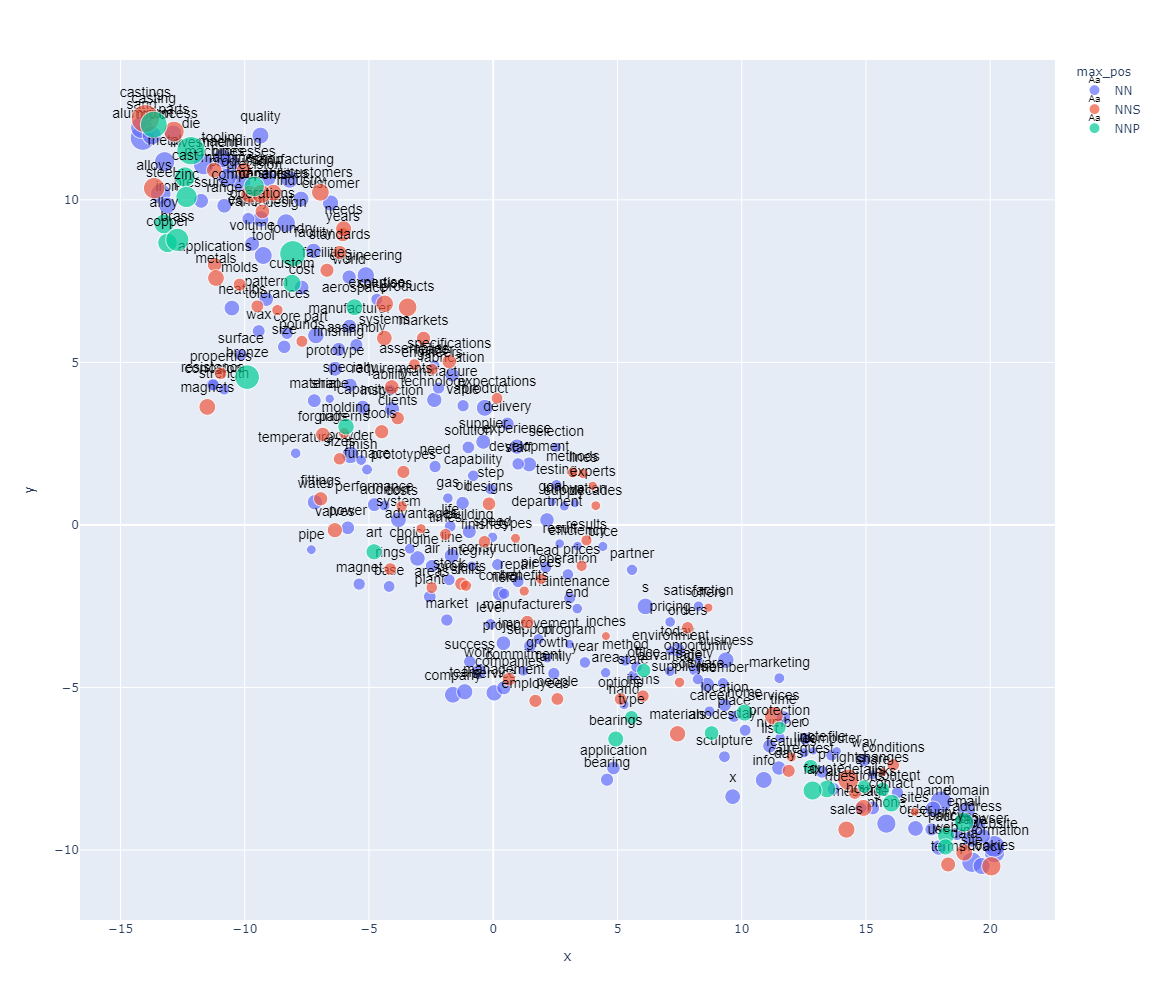

In [13]:
px.scatter(coords_1.reset_index(), 'x', 'y', 
           text='term_str', 
           color='max_pos', 
           hover_name='term_str',          
           size='mean_tfidf',
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

In [14]:
def complete_analogy(model, A, B, C, n=2):
    try:
        cols = ['term', 'sim']
        return pd.DataFrame(model.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
    except KeyError as e:
        print('Error:', e)
        return None
    
def get_most_similar(model, positive, negative=None):
    return pd.DataFrame(model.wv.most_similar(positive, negative), columns=['term', 'sim'])

In [15]:
# great
complete_analogy(model_1, 'products', 'product', 'castings', 3)

term       sim
0  casting  0.996743
1  process  0.996695
2     mold  0.995791

In [16]:
# Not Bad.
complete_analogy(model_1, 'metal', 'steel', 'alloy', 3)

term       sim
0  copper  0.993963
1   brass  0.990562
2    iron  0.986748

In [17]:
# should be castings
complete_analogy(model_1, 'industry', 'industries', 'casting', 3)

term       sim
0      sand  0.997540
1  aluminum  0.995511
2      mold  0.995178

In [18]:
complete_analogy(model_1, 'site', 'com', 'customer', 3)

term       sim
0  customers  0.966555
1      needs  0.965260
2      years  0.962621

In [19]:
get_most_similar(model_1, 'quality')

term       sim
0  manufacturing  0.993137
1      customers  0.992500
2      processes  0.990401
3       industry  0.989996
4     production  0.989725
5      machining  0.989361
6     components  0.989286
7     industries  0.989081
8      precision  0.989073
9   capabilities  0.988889

In [20]:
get_most_similar(model_1, 'magnet')

term       sim
0         rings  0.997984
1        choice  0.997966
2         speed  0.997688
3    advantages  0.997495
4  construction  0.997197
5      finishes  0.997150
6          base  0.997055
7           air  0.996911
8          lead  0.996796
9        pieces  0.996629

In [21]:
get_most_similar(model_1, 'castings')

term       sim
0     casting  0.998288
1    aluminum  0.996790
2        sand  0.994066
3        mold  0.993823
4     process  0.991580
5       parts  0.991214
6         die  0.988266
7       metal  0.987513
8        cast  0.980328
9  investment  0.976331

In [22]:
get_most_similar(model_1, 'metal')

term       sim
0        cast  0.996180
1        mold  0.995447
2        zinc  0.995027
3         die  0.995027
4     process  0.993421
5      alloys  0.992954
6        iron  0.992897
7  investment  0.992707
8       steel  0.992417
9       parts  0.991717

In [23]:
get_most_similar(model_1, 'privacy')

term       sim
0         site  0.998130
1         data  0.997719
2          web  0.996229
3      cookies  0.995622
4       policy  0.995378
5          use  0.994937
6      website  0.993089
7  information  0.992416
8       access  0.992299
9         page  0.987802

In [24]:
get_most_similar(model_1, 'business')

term       sim
0        member  0.994139
1  satisfaction  0.993824
2        career  0.993750
3   opportunity  0.992819
4           day  0.992630
5      location  0.992519
6           job  0.992203
7         today  0.991080
8        safety  0.990936
9      software  0.989631

In [25]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

def hca(sims, labels, linkage_method='ward', color_thresh=.3):
    tree = sch.linkage(sims, method=linkage_method)
    fig_height = len(labels) / 3
    plt.figure()
    fig, axes = plt.subplots(figsize=(10, fig_height))
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)

def plot_terms_tree(coords, terms_n = 100, color_thresh=1):
    term_filter = coords.index.str.len() > 2
    M = coords[coords.index.str.len() > 2].sort_values('mean_tfidf', ascending=False).vector.head(terms_n)
    IDX = coords.loc[M.index].index #term_str
    hca(M.to_list(), IDX.to_list(), color_thresh=color_thresh)

<Figure size 432x288 with 0 Axes>

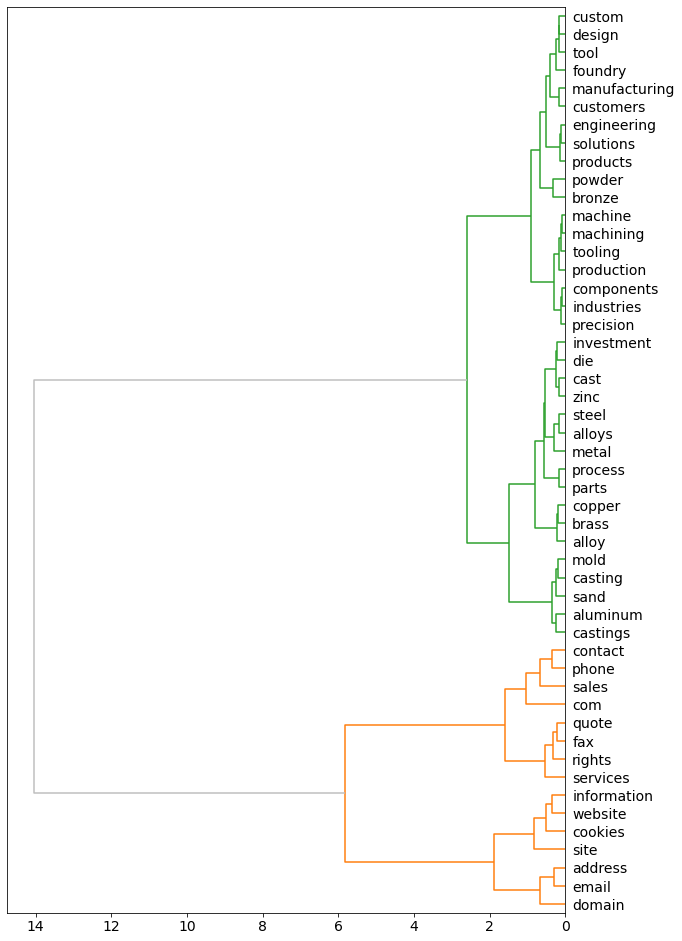

In [26]:
plot_terms_tree(coords_1, color_thresh=9, terms_n=50)

### Model 2: FINAL MODEL

In [27]:
# word2vec parameters
w2v_params = dict(
    window = 5,
    vector_size = 50,
    min_count = 20,
    workers = 4
)

In [28]:
model_2 = word2vec.Word2Vec(DOCS, **w2v_params)

In [29]:
coords_2 = pd.DataFrame(
    dict(
        vector = [model_2.wv.get_vector(w) for w in model_2.wv.index_to_key], 
        term_str = model_2.wv.index_to_key
    )).set_index('term_str')

In [30]:
tsne_engine_2 = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
tsne_model_2 = tsne_engine_2.fit_transform(coords_2.vector.to_list())

In [31]:
coords_2['x'] = tsne_model_2[:,0]
coords_2['y'] = tsne_model_2[:,1]

In [32]:
if coords_2.shape[1] == 3:
    coords_2 = coords_2.merge(VOCAB.reset_index(), on='term_str')
    coords_2 = coords_2.set_index('term_str')

### Terms and embeddings, either added to the VOCAB table or as a separate table with a shared index with the VOCAB table.

In [33]:
coords_2

vector          x  \
term_str                                                                  
quality    [0.065570064, -0.41915667, -0.4725266, 0.40167... -30.709665   
products   [0.01348228, -0.20026508, -0.39020002, 0.23597... -22.988716   
castings   [-0.14231625, -0.34984565, -0.9033165, 0.82170... -38.744041   
customers  [0.086776175, -0.39764294, -0.43540826, 0.3178... -29.556515   
parts      [-0.038096342, -0.29454994, -0.736303, 0.59309... -36.611755   
...                                                      ...        ...   
cookie     [0.035047874, 0.18894047, -0.019078705, 0.0262...  18.050837   
operators  [-0.007005832, -0.018792598, -0.18765186, 0.11...   6.963974   
policies   [0.026769556, 0.12664895, -0.059725255, 0.0421...  17.212343   
grain      [-0.013644802, 0.0012327919, -0.23754226, 0.19...  -1.646086   
ofhbd      [-0.034283724, -0.0036667883, -0.09175958, 0.0...  14.731401   

                   y  index     n         p          i  n_chars max_pos  \
term_str                                                                  
quality    16.565584      0  1369  0.009497   6.718315        7      NN   
products   16.822636      2  1199  0.008318   6.909605        8     NNS   
castings   12.683642      1  1228  0.008519   6.875126        8     NNS   
customers  16.580948     13   678  0.004703   7.732080        9     NNS   
parts      13.925336     10   743  0.005154   7.600003        5     NNS   
...              ...    ...   ...       ...        ...      ...     ...   
cookie     -8.708959    565    47  0.000326  11.582632        6     NNP   
operators -20.652159   1086    24  0.000166  12.552259        9     NNS   
policies   -8.458417    781    34  0.000236  12.049758        8     NNS   
grain     -19.849710   1330    20  0.000139  12.815293        5      NN   
ofhbd     -21.102697   1302    20  0.000139  12.815293        5      NN   

           n_pos                       cat_pos      dfidf  mean_tfidf  
term_str                                                               
quality        3          {'NNS', 'NNP', 'NN'}  22.920115    0.020423  
products       4  {'NNS', 'NNP', 'NN', 'NNPS'}  33.358238    0.024701  
castings       3        {'NNS', 'NNP', 'NNPS'}  44.741763    0.056828  
customers      3        {'NNS', 'NNP', 'NNPS'}  38.840662    0.022331  
parts          3        {'NNS', 'NNP', 'NNPS'}  43.013495    0.030131  
...          ...                           ...        ...         ...  
cookie         2                 {'NNP', 'NN'}  14.771213    0.006443  
operators      2                {'NNS', 'NNP'}  18.633905    0.003567  
policies       3        {'NNS', 'NNP', 'NNPS'}  17.721313    0.004188  
grain          1                        {'NN'}  18.633905    0.003307  
ofhbd          1                        {'NN'}   2.477121    0.002502  

[716 rows x 13 columns]

In [34]:
coords_2.to_csv("COORDS.csv")

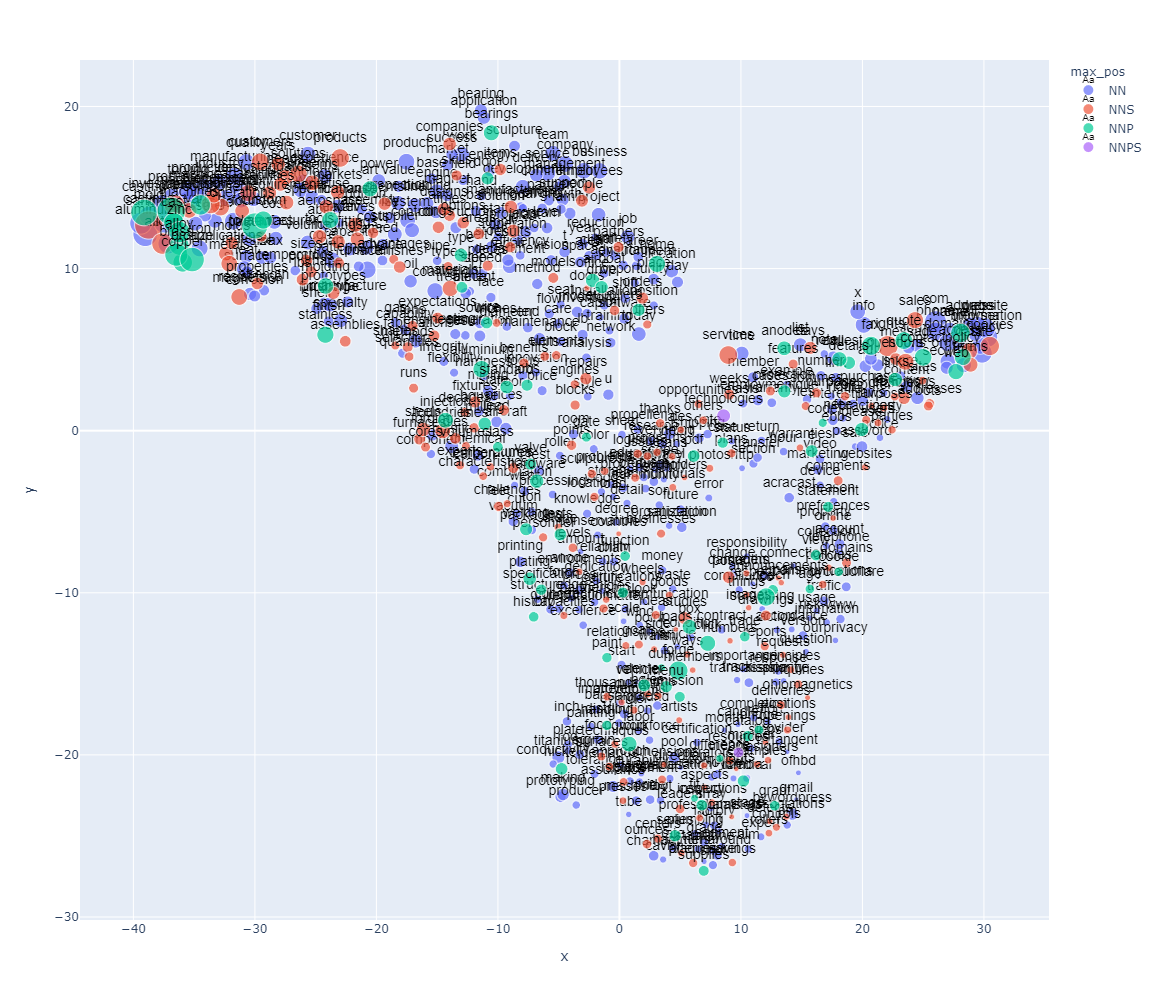

In [35]:
px.scatter(coords_2.reset_index(), 'x', 'y', 
           text='term_str', 
           color='max_pos', 
           hover_name='term_str',          
           size='mean_tfidf',
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

<Figure size 432x288 with 0 Axes>

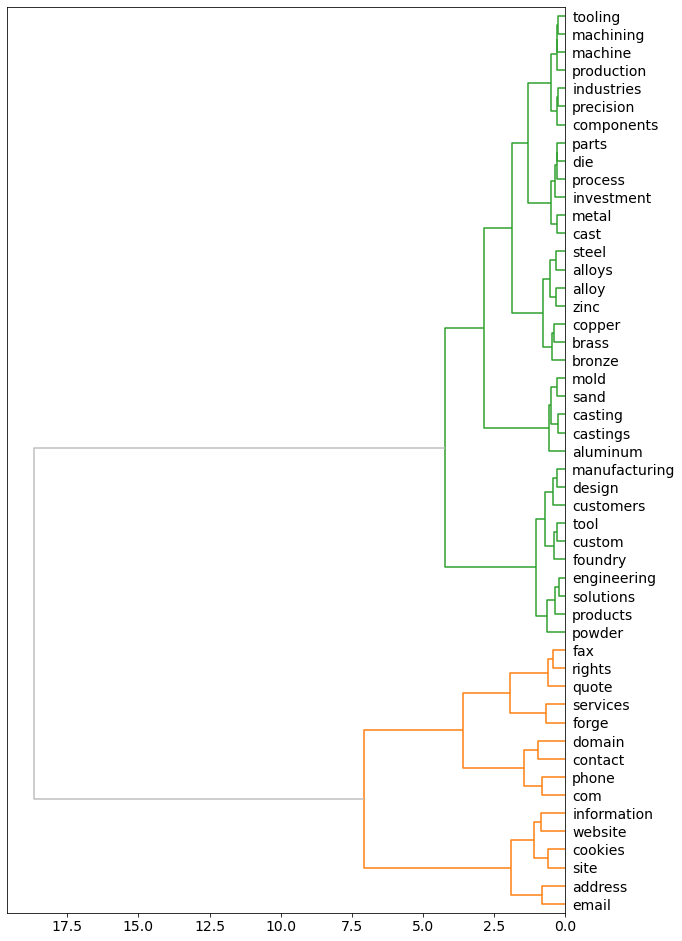

In [36]:
plot_terms_tree(coords_2, color_thresh=9, terms_n=50)

In [37]:
complete_analogy(model_2, 'products', 'product', 'castings', 3)

term       sim
0        mold  0.992515
1  investment  0.990887
2       metal  0.990784

In [38]:
complete_analogy(model_2, 'metal', 'steel', 'alloy', 3)

term       sim
0  copper  0.986490
1   brass  0.985999
2  bronze  0.983452

In [39]:
complete_analogy(model_2, 'industry', 'industries', 'casting', 3)

term       sim
0      sand  0.994056
1  castings  0.992711
2      mold  0.992389

In [40]:
complete_analogy(model_2, 'site', 'com', 'customer', 3)

term       sim
0   products  0.906111
1      needs  0.900808
2  customers  0.899813

In [41]:
get_most_similar(model_2, 'quality')

term       sim
0      customers  0.996413
1  manufacturing  0.989686
2       industry  0.988489
3          years  0.986771
4         design  0.986008
5      standards  0.985689
6   capabilities  0.982341
7          needs  0.981382
8       facility  0.981032
9      equipment  0.980999

In [42]:
get_most_similar(model_2, 'magnet')

term       sim
0    combination  0.997713
1   temperatures  0.997390
2      treatment  0.997318
3          piece  0.997026
4         vacuum  0.996867
5       hardness  0.996796
6          speed  0.996780
7           wire  0.996743
8  specification  0.996547
9         source  0.996468

In [43]:
get_most_similar(model_2, 'castings')

term       sim
0     casting  0.997742
1        mold  0.995247
2  investment  0.994948
3    aluminum  0.994870
4        sand  0.992886
5       metal  0.991780
6         die  0.991469
7        cast  0.988201
8       parts  0.987517
9     process  0.986003

In [44]:
get_most_similar(model_2, 'privacy')

term       sim
0       policy  0.995408
1         data  0.992547
2         site  0.992420
3          use  0.991844
4          web  0.990413
5  information  0.989499
6      cookies  0.987168
7        terms  0.985200
8       access  0.983041
9      website  0.983010

In [45]:
get_most_similar(model_2, 'business')

term       sim
0     employees  0.991647
1  satisfaction  0.990131
2         today  0.988787
3    commitment  0.988321
4        career  0.986965
5    management  0.986937
6       company  0.986785
7             s  0.986199
8        people  0.986015
9       support  0.985650

## Model 3

In [46]:
# word2vec parameters
w2v_params = dict(
    window = 5,
    vector_size = 50,
    min_count = 50,
    workers = 4
)

In [47]:
model_3 = word2vec.Word2Vec(DOCS, **w2v_params)

In [48]:
coords_3  = pd.DataFrame(
    dict(
        vector = [model_3.wv.get_vector(w) for w in model_3.wv.index_to_key], 
        term_str = model_3.wv.index_to_key
    )).set_index('term_str')

In [49]:
tsne_engine_3 = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
tsne_model_3 = tsne_engine_3.fit_transform(coords_1.vector.to_list())

In [50]:
coords_3['x'] = tsne_model_3[:,0]
coords_3['y'] = tsne_model_3[:,1]

In [51]:
if coords_3.shape[1] == 3:
    coords_3 = coords_3.merge(VOCAB.reset_index(), on='term_str')
    coords_3 = coords_3.set_index('term_str')

### Terms and embeddings, either added to the VOCAB table or as a separate table with a shared index with the VOCAB table.

In [52]:
coords_3

vector          x  \
term_str                                                                    
quality      [0.007242675, -0.5755602, -0.9660618, 0.207395...  -9.367032   
products     [0.019218493, -0.4161412, -0.65485626, 0.01351...  -3.444940   
castings     [-0.29061276, -0.5425417, -1.5047671, 0.557182... -13.999911   
customers    [0.074579835, -0.5474552, -0.77865887, 0.08849...  -6.956171   
parts        [-0.16113508, -0.4165371, -1.1664863, 0.354164... -12.850760   
...                                                        ...        ...   
program      [0.07312083, -0.317452, -0.45320028, -0.041424...   3.068497   
protection   [0.17090121, -0.17275172, -0.1098602, -0.14573...  11.517477   
software     [0.12577975, -0.23499973, -0.28096214, -0.0822...   8.234579   
file         [0.24711391, -0.11425467, 0.032653082, -0.2424...  13.823512   
maintenance  [0.041104108, -0.30886716, -0.46711847, -0.020...   3.076071   

                     y  index     n         p          i  n_chars max_pos  \
term_str                                                                    
quality      11.976635      0  1369  0.009497   6.718315        7      NN   
products      6.695321      2  1199  0.008318   6.909605        8     NNS   
castings     12.495385      1  1228  0.008519   6.875126        8     NNS   
customers    10.231357     13   678  0.004703   7.732080        9     NNS   
parts        12.102024     10   743  0.005154   7.600003        5     NNS   
...                ...    ...   ...       ...        ...      ...     ...   
program      -3.666410    399    63  0.000437  11.159941        7      NN   
protection   -6.241228    169   128  0.000888  10.137221       10     NNP   
software     -4.743595    442    59  0.000409  11.254578        8      NN   
file         -6.957466    504    52  0.000361  11.436782        4      NN   
maintenance  -2.245626    307    81  0.000562  10.797371       11      NN   

             n_pos                       cat_pos      dfidf  mean_tfidf  
term_str                                                                 
quality          3          {'NNS', 'NNP', 'NN'}  22.920115    0.020423  
products         4  {'NNS', 'NNP', 'NN', 'NNPS'}  33.358238    0.024701  
castings         3        {'NNS', 'NNP', 'NNPS'}  44.741763    0.056828  
customers        3        {'NNS', 'NNP', 'NNPS'}  38.840662    0.022331  
parts            3        {'NNS', 'NNP', 'NNPS'}  43.013495    0.030131  
...            ...                           ...        ...         ...  
program          2                 {'NNP', 'NN'}  31.634041    0.006879  
protection       2                 {'NNP', 'NN'}  36.681417    0.012354  
software         2                 {'NNP', 'NN'}  34.098831    0.009113  
file             2                 {'NNP', 'NN'}  29.426974    0.006192  
maintenance      2                 {'NNP', 'NN'}  35.002451    0.010582  

[290 rows x 13 columns]

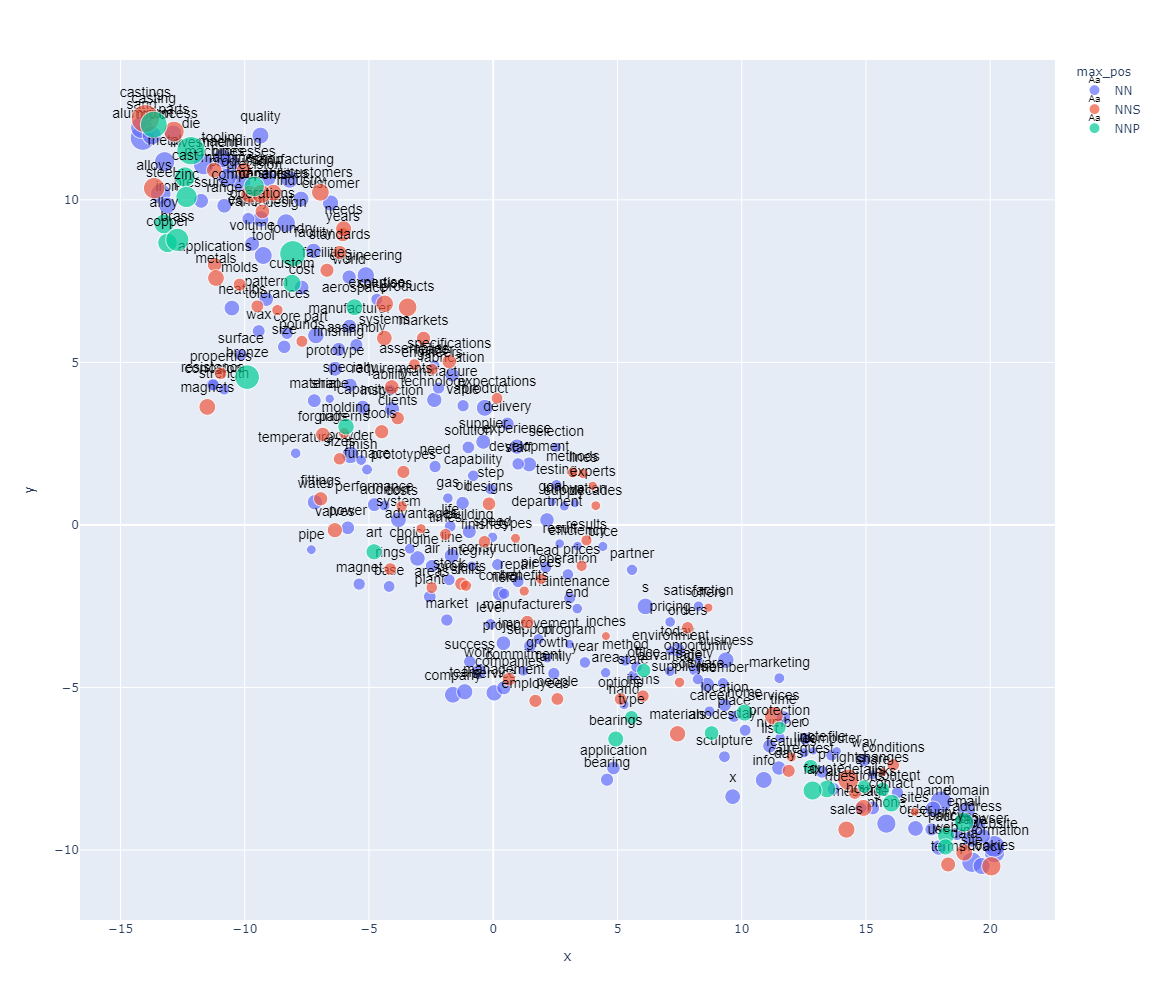

In [53]:
px.scatter(coords_3.reset_index(), 'x', 'y', 
           text='term_str', 
           color='max_pos', 
           hover_name='term_str',          
           size='mean_tfidf',
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

<Figure size 432x288 with 0 Axes>

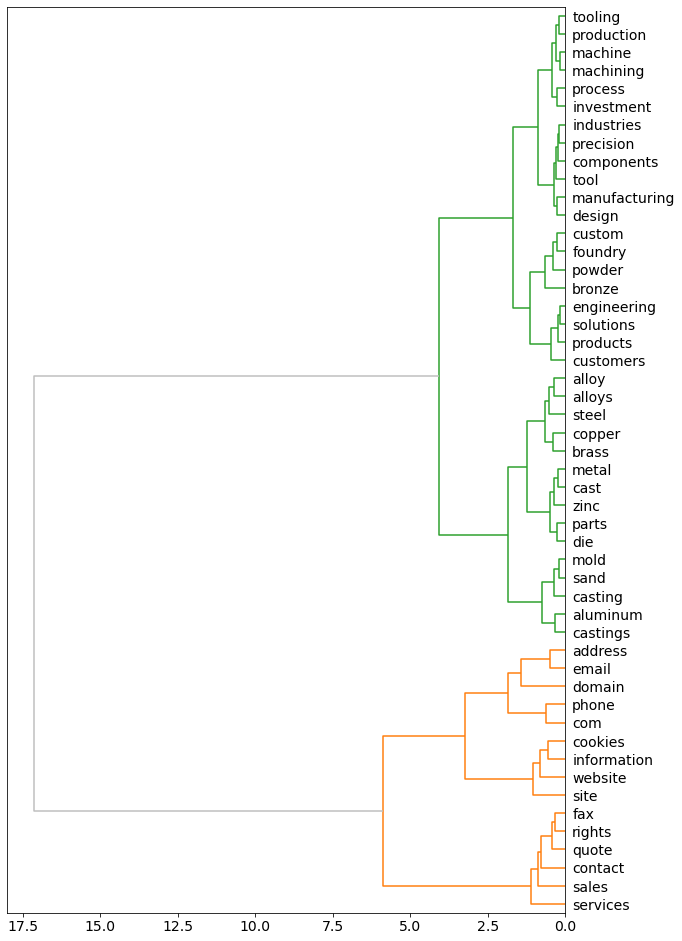

In [54]:
plot_terms_tree(coords_3, color_thresh=9, terms_n=50)

In [55]:
complete_analogy(model_3, 'products', 'product', 'castings', 3)

term       sim
0  casting  0.995202
1      die  0.991906
2     mold  0.989934

In [56]:
complete_analogy(model_3, 'metal', 'steel', 'alloy', 3)

term       sim
0  alloys  0.988130
1  copper  0.982927
2   brass  0.978905

In [57]:
complete_analogy(model_3, 'industry', 'industries', 'casting', 3)

term       sim
0      mold  0.995348
1      sand  0.993590
2  castings  0.992421

In [58]:
complete_analogy(model_3, 'site', 'com', 'customer', 3)

term       sim
0       company  0.929174
1  expectations  0.925222
2          team  0.915848

In [59]:
get_most_similar(model_3, 'quality')

term       sim
0  manufacturing  0.989910
1       industry  0.988304
2          years  0.983578
3     industries  0.982814
4      standards  0.981590
5         design  0.981078
6     production  0.980975
7      equipment  0.980855
8      precision  0.980413
9       facility  0.980007

In [60]:
get_most_similar(model_3, 'magnet')

term       sim
0    speed  0.992756
1    rings  0.990202
2      air  0.990006
3      oil  0.989788
4   pieces  0.988471
5    power  0.988188
6   choice  0.988042
7  options  0.987329
8     lead  0.987174
9    field  0.987048

In [61]:
get_most_similar(model_3, 'castings')

term       sim
0   casting  0.995889
1  aluminum  0.995067
2       die  0.993105
3      mold  0.991283
4      sand  0.990256
5     metal  0.989445
6      cast  0.989266
7     parts  0.988411
8  machines  0.982255
9      zinc  0.979131

In [62]:
get_most_similar(model_3, 'privacy')

term       sim
0        sites  0.997709
1       policy  0.996844
2          use  0.994132
3         site  0.990057
4      cookies  0.990028
5      content  0.989795
6         data  0.989179
7          web  0.986170
8  information  0.986151
9     security  0.986032

In [63]:
get_most_similar(model_3, 'business')

term       sim
0  satisfaction  0.988860
1           job  0.982860
2           day  0.981565
3     employees  0.981269
4      location  0.979180
5   opportunity  0.979095
6        career  0.977987
7         today  0.976259
8       service  0.974960
9        safety  0.973600